In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano

import pymc3 as pm

%matplotlib inline

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [2]:
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [3]:
stocks = ['GOOG']
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close', 'Name']]
df_stocks.shape

(1258, 3)

In [4]:
df_stocks = df_stocks.pivot(index='Date', columns='Name', values='Close')
df_stocks.head()

Name,GOOG
Date,
2012-08-13,329.67
2012-08-14,334.00
2012-08-15,333.44
2012-08-16,336.10
2012-08-17,338.23


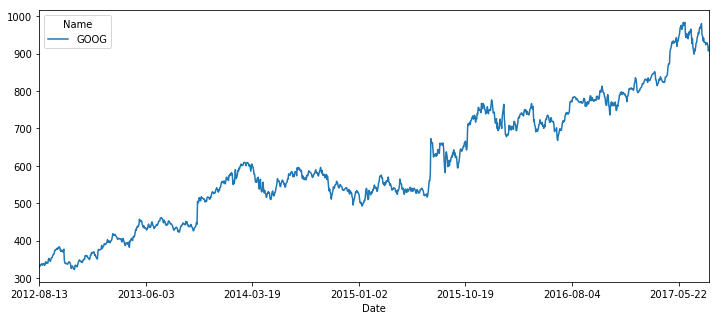

In [5]:
df_stocks.plot(figsize=(12, 5))
plt.show()

In [6]:
t = np.arange(len(df_stocks))
t = (t-t.mean())/t.std()

y = df_stocks.values[-100:]
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [8]:
n_samples = 500
with pm.Model() as model:
    σ = pm.Exponential('σ', 1)
    f = pm.GaussianRandomWalk('f', sd=σ, shape=len(y))
    
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y', mu=f, sd=sd, observed=y)
    
    trace = pm.sample(n_samples, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 14,300:  13%|█▎        | 26289/200000 [00:05<00:36, 4717.76it/s]
Convergence archived at 26700
Interrupted at 26,700 [13%]: Average Loss = 1.8221e+05
100%|█████████▉| 999/1000 [01:04<00:00, 19.69it/s]/Users/sachin/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.669370797818, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [01:04<00:00, 15.58it/s]
/Users/sachin/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 2 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)


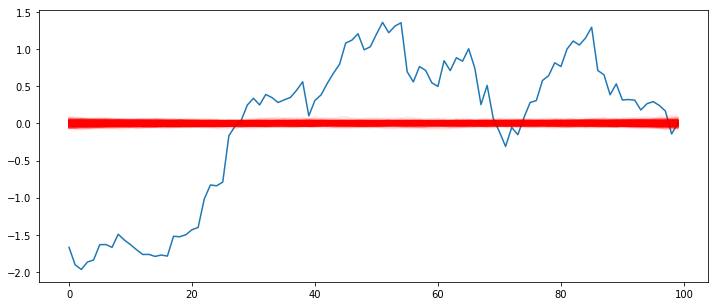

In [13]:
plt.figure(figsize=(12,5))
plt.plot(y)
plt.plot(trace['f'].T, 'r', alpha=.05)
plt.show()

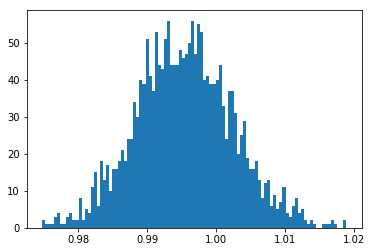

In [14]:
plt.hist(trace['sd'], 100)
plt.show()

In [27]:
n_samples = 500
with pm.Model() as model:
    σ = pm.Exponential('σ', 1/np.abs(np.diff(y,axis=0)).mean())
    f = pm.GaussianRandomWalk('f', sd=σ, shape=len(y))
    
    sd = pm.Bound(pm.Normal, lower=0.0, upper=0.1)('sd', mu=0.0, sd=1.0, testval=1.0)
    likelihood = pm.Normal('y', mu=f, sd=sd, observed=y)
    
    trace = pm.sample(n_samples, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 4.8624e+05:  24%|██▎       | 47380/200000 [00:10<00:34, 4474.85it/s]
Convergence archived at 47800
Interrupted at 47,800 [23%]: Average Loss = 6.7532e+05
100%|██████████| 1000/1000 [01:30<00:00, 11.09it/s]


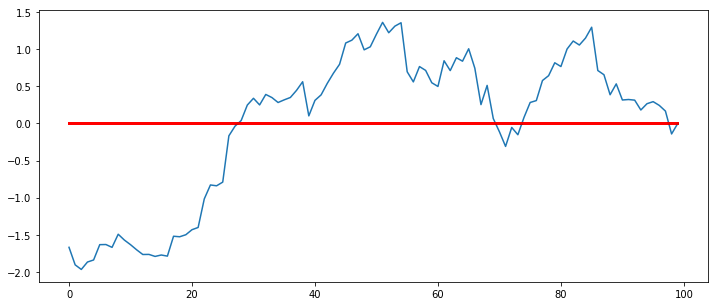

In [28]:
plt.figure(figsize=(12,5))
plt.plot(y)
plt.plot(trace['f'].T, 'r', alpha=.05)
plt.show()

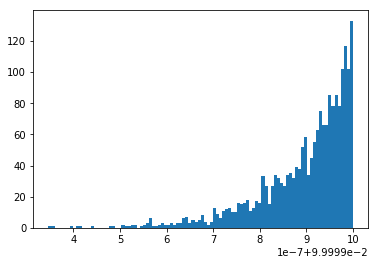

In [29]:
plt.hist(trace['sd'], 100)
plt.show()

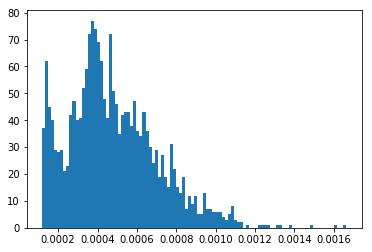

In [30]:
plt.hist(trace['σ'], 100)
plt.show()

## Volatility Process

In [33]:
df_stocks['lnP'] = np.log10(df_stocks.GOOG)
df_stocks['log_return'] = df_stocks.lnP.diff()

In [34]:
df_stocks.head()

Name,GOOG,lnP,log_return
Date,,,
2012-08-13,329.67,2.518079,NaN
2012-08-14,334.00,2.523746,0.005667
2012-08-15,333.44,2.523018,-0.000729
2012-08-16,336.10,2.526469,0.003451
2012-08-17,338.23,2.529212,0.002744


In [35]:
returns = df_stocks.log_return[-250:]

In [37]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1./10, testval=5.)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s))

    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=returns)
    trace = pm.sample(n_samples, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -917.68:  37%|███▋      | 73471/200000 [00:14<00:25, 4974.64it/s]
Convergence archived at 73900
Interrupted at 73,900 [36%]: Average Loss = 116.5
 88%|████████▊ | 879/1000 [01:03<00:08, 13.96it/s]/Users/sachin/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.502383584651, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 90%|█████████ | 903/1000 [01:04<00:05, 16.83it/s]/Users/sachin/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 2 does not match the target. It is 0.607684645963, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [01:11<00:00, 14.03it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1294b80b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a85f208>]], dtype=object)

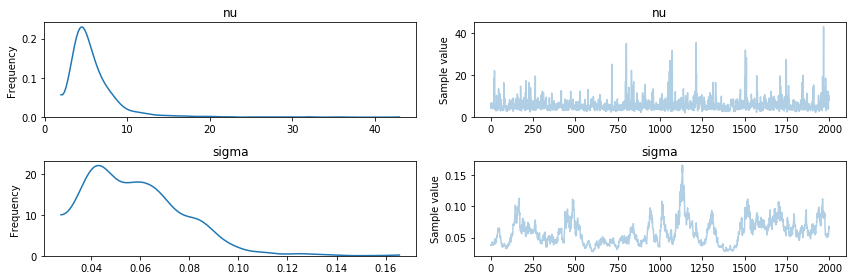

In [39]:
pm.traceplot(trace, [nu, sigma], combined=True)

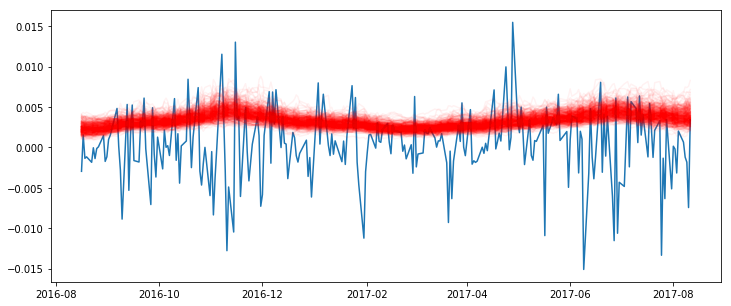

In [51]:
dates = np.array([np.datetime64(d) for d in df_stocks.index])[-250:]

plt.figure(figsize=(12, 5))
plt.plot(dates, returns)
plt.plot(dates, 1/np.exp(trace['s',::5].T), 'r', alpha=.05)
plt.show()